# M1 Downstream Classification Task

In this notebook a multiclass text classification is implemented. 
An LSTM is used with an embedding layer as the first layer. This layer uses the pretrained embeddings and will not be trained during the classification task.

In [1]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import gensim
from gensim.models import Word2Vec, FastText, KeyedVectors
%matplotlib inline

In [2]:
import tensorflow 

from keras import layers,optimizers, regularizers

from keras.models import Sequential, Model

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, Tokenizer

from keras.metrics import categorical_accuracy
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.backend import mean

from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten, multiply, Lambda
from keras.layers import MaxPooling1D, Embedding, Bidirectional, CuDNNLSTM, RepeatVector
from keras.layers import MaxPooling2D, concatenate, SpatialDropout1D

from keras.layers.core import Reshape, Flatten, Permute
from keras.layers.normalization import BatchNormalization

from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
#Load the three prepared embeddings

#Load pretrained FastText
model_ft =  KeyedVectors.load_word2vec_format('../WordEmbeddings/FastText/cc.de.300.vec') 

#Load domain specific FastText
model_ds_ft = FastText.load("../WordEmbeddings/ft_ds.model")

#Load domain specific word2vec
model_ds_w2v = Word2Vec.load("../WordEmbeddings/w2v_ds.model")


In [18]:
#Load the training and test data for the text classification task

test_data = pd.read_pickle("../Data/testset.pkl")
train_data = pd.read_pickle("../Data/trainset.pkl")

train_data=train_data[train_data.label!="A"]
test_data=test_data[test_data.label!="A"]

vocab_base = pd.concat([train_data, test_data])

In [19]:
NUM_WORDS=20000
tokenizer = Tokenizer(num_words=NUM_WORDS,
                      lower=True)
tokenizer.fit_on_texts(vocab_base.CR_s)
sequences_train = tokenizer.texts_to_sequences(train_data.CR_s)
sequences_test = tokenizer.texts_to_sequences(test_data.CR_s)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 36785 unique tokens.


In [20]:
functions=train_data.label.unique()
dic={}
for i,func in enumerate(functions):
    dic[func]=i
train_labels=train_data.label.apply(lambda x:dic[x])
test_labels = test_data.label.apply(lambda x:dic[x])
y_test_multiclass = test_labels.tolist() #needed later for confusion matrix

In [21]:
X_train = pad_sequences(sequences_train)
y_train = to_categorical(np.asarray(train_labels[train_data.index]))

X_test = pad_sequences(sequences_test,maxlen=X_train.shape[1])
y_test = to_categorical(np.asarray(test_labels[test_data.index]))
print('Shape of X_train and X_test tensor:', X_train.shape, X_test.shape)
print('Shape of label train and test tensor:', y_train.shape, y_test.shape)

Shape of X_train and X_test tensor: (7556, 405) (841, 405)
Shape of label train and test tensor: (7556, 8) (841, 8)


In [22]:
#Switch between the three loaded embeddings
embed=model_ds_w2v

pretrained_weights = embed.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape

In [23]:
#Convert embedding to keras embedding layer

MAX_NB_WORDS = len(word_index)
EMBEDDING_DIM = emdedding_size
nb_words = len(word_index)+1
# we initialize the matrix with random numbers
ft_matrix = (np.random.rand(nb_words, EMBEDDING_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = embed.wv[word]
        # words not found in embedding index will be all-zeros.
        ft_matrix[i] = embedding_vector
    except:
        pass        

In [24]:
# Balance the training data

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_data.label),
                                                 train_data.label)
print(class_weights)

# Run this with test_data and compare!

class_weights_test = class_weight.compute_class_weight('balanced',
                                                 np.unique(test_data.label),
                                                 test_data.label)
print(class_weights_test)

[ 0.59216301  3.02724359  2.04437229  5.72424242  0.363409   10.15591398
  9.35148515  0.42373262]
[ 0.54468912  3.18560606  2.14540816  4.38020833  0.38507326 17.52083333
 13.140625    0.4122549 ]


In [25]:
# Build attention layer
# Source: Modified version of:  https://github.com/philipperemy/keras-attention-mechanism

SINGLE_ATTENTION_VECTOR = False

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs) #Dense layer operates only on last dimension of array. hence we rotate time in last place
    a = Dense(405, activation='softmax')(a) #Weights are the attention matrix: 405 x 405 
    if SINGLE_ATTENTION_VECTOR: #if single layer, then take mean over all hidden dimensions, then broadcast mean back over hidden dimensiosn
        a = Lambda(lambda x: mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a) #permute time back in second place, hidden dimensions back to last
    # output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

In [26]:
# Build LSTM network with embedding layer and attention layer

vocab_size = len(tokenizer.word_index) + 1
input_dim = X_train.shape[1]  # length padded sequences

inputs = Input(name='inputs',shape=[input_dim])
layer = Embedding(input_dim=vocab_size, 
                            output_dim=EMBEDDING_DIM, 
                            weights=[ft_matrix],
                            trainable=False)(inputs)
lstm_out = LSTM(80,dropout=0.4,recurrent_dropout=0.4, return_sequences=True)(layer)
lstm_out = Dropout(0.4)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = Flatten()(attention_mul)
output = Dense(len(functions), activation='softmax')(attention_mul)


model = Model(input=[inputs], output=output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [27]:
#Compile the model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 405)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 405, 300)     11035800    inputs[0][0]                     
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 405, 80)      121920      embedding_2[0][0]                
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 405, 80)      0           lstm_2[0][0]                     
____________________________________________________________________________________________

In [28]:
# Train the model 

history = model.fit(X_train, y_train,
                    validation_split=0,
                    validation_data=(X_test, y_test),
                    epochs=50, 
                    batch_size=16,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], 
                    shuffle=True,
                    class_weight=class_weights
                   )

Train on 7556 samples, validate on 841 samples
Epoch 1/50
7556/7556 [==============================] - 137s 18ms/step - loss: 1.3233 - accuracy: 0.5057 - val_loss: 0.9644 - val_accuracy: 0.6849
Epoch 2/50
7556/7556 [==============================] - 137s 18ms/step - loss: 1.0234 - accuracy: 0.6544 - val_loss: 0.8495 - val_accuracy: 0.7229
Epoch 3/50
7556/7556 [==============================] - 136s 18ms/step - loss: 0.9158 - accuracy: 0.6850 - val_loss: 0.7761 - val_accuracy: 0.7598
Epoch 4/50
7556/7556 [==============================] - 138s 18ms/step - loss: 0.8496 - accuracy: 0.7098 - val_loss: 0.7250 - val_accuracy: 0.7598
Epoch 5/50
7556/7556 [==============================] - 138s 18ms/step - loss: 0.7948 - accuracy: 0.7250 - val_loss: 0.6939 - val_accuracy: 0.7586
Epoch 6/50
7556/7556 [==============================] - 134s 18ms/step - loss: 0.7472 - accuracy: 0.7354 - val_loss: 0.6491 - val_accuracy: 0.7776
Epoch 7/50
7556/7556 [==============================] - 134s 18ms/step 

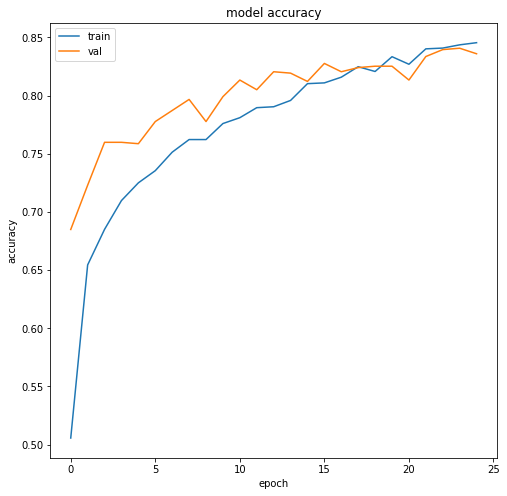

In [29]:
#Plot trainng vs. testing accuracy

plt.figure(figsize=(8,8));
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

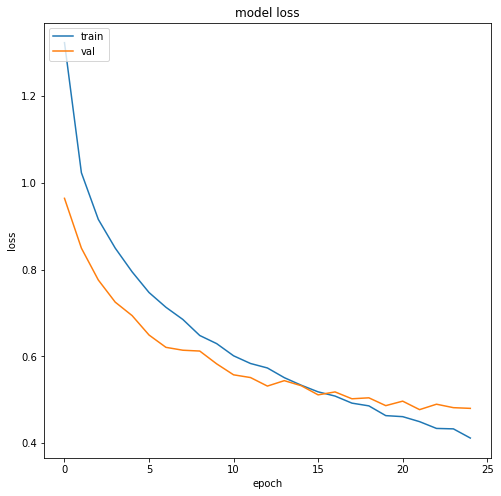

In [30]:
#Plot training vs. testing loss

plt.figure(figsize=(8,8));
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
#Evaluate on test data.

print(model.evaluate(X_test,y_test))
print(model.metrics_names)

841/841 [==============================] - 3s 4ms/step
[0.47998920455132027, 0.8359096050262451]
['loss', 'accuracy']


[[ 22   0   1   1   0   0   0   0]
 [  0 171  16   2   2   2   0   0]
 [  0   5 213  20   5  11   1   0]
 [  0   5  22 235   3   4   4   0]
 [  0   0   2   3  27   1   0   0]
 [  0   6   6   6   2  27   2   0]
 [  0   0   3   2   0   0   3   0]
 [  0   0   0   0   0   0   1   5]]


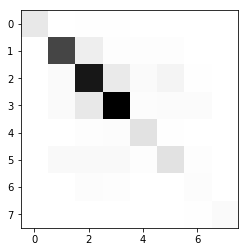

In [32]:
#Print confusion matrix 

from sklearn.metrics import confusion_matrix
%matplotlib inline
y_pred = model.predict(X_test).argmax(axis=1)

cm = confusion_matrix(y_test_multiclass, y_pred, labels=None, sample_weight=None )
  
print(cm)
plt.imshow(cm, cmap='binary')

In [46]:
# Introspection to see what the attention layer might have learned (to be continued...)

for layer in model.layers: print(layer.get_config(), layer.get_weights())

{'batch_input_shape': (None, 405), 'dtype': 'float32', 'sparse': False, 'name': 'inputs'} []
{'name': 'embedding_3', 'trainable': False, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 36786, 'output_dim': 300, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None} [array([[ 2.1104127e-02, -6.6042505e-02, -5.9566073e-02, ...,
         3.9218254e-02,  1.6524125e-03, -5.3010704e-03],
       [ 5.6211400e-01, -1.2752330e+00,  3.6714014e-01, ...,
         7.1641594e-01, -2.0809224e+00,  3.8616073e-01],
       [ 5.9366381e-01, -5.4290450e-01,  6.1892653e-01, ...,
         2.5513845e-02, -1.4185814e+00, -8.9313889e-01],
       ...,
       [ 9.3665056e-02, -6.3305318e-02, -4.2916533e-02, ...,
        -3.6718938e-02, -6.4458489e-02, -9.1600843e-02],
       [ 6.9873564e-02,  8.7692